## import

In [1]:
import numpy as np
#from scipy import stats
import matplotlib.pyplot as plt
import matplotlib

import torch 
from torch import distributions
from torch import nn
from torch.utils import data

## MCMC

In [2]:
def MCMC_sampler(E,xstart=0.,n_sample=10000,std=0.1,n_stride=10):
  samples=[]
  for j in range(n_stride):
    x_cur=xstart
    e_cur=E(x_cur)
    for i in range(int(n_sample/10)):
      dx=std*np.random.normal()
      x_prop=x_cur+dx
      e_prop=E(x_prop)
      e_diff=e_prop-e_cur
      log_r=-np.log(np.random.uniform())
      acc=float(log_r>e_diff)
      rej=1.-acc
      x_cur=x_prop*acc+x_cur*rej
      e_cur=e_prop*acc+e_cur*rej
      samples.append(x_cur)  
  return samples

## data

#### function

In [3]:
def E( x, a=1, b=-6, c=0):
  return a*x**4+b*x**2+c*x

In [4]:
def brute_sample(E,n_sample=10000):
  half_num=int(n_sample/2)
  xl=MCMC_sampler(E,-2,half_num)
  xr=MCMC_sampler(E,2,half_num)
  x1=np.append(xl,xr)
  x2=np.random.normal(size=n_sample)
#  print(len(xl),len(x2))
  x=np.vstack((x1,x2)).T
  return x

In [5]:
def plot_energy(x):
  counts, bins = np.histogram(x, bins = 200 )
  anchors = (bins[1:] + bins[:-1]) / 2
  probs = counts / np.sum(counts)

  anchors = anchors[np.where(probs > 0.0001)]
  probs = probs[np.where(probs > 0.0001)]

  f = -np.log(probs)
  fn = f - np.min(f)
  x_mesh = np.linspace(-2.5,2.5,1000)
  E_mesh = E(x_mesh)
  E_mesh=E_mesh-E_mesh.min()
  plt.scatter(anchors, fn) 

  plt.xlabel("$x_1$")
  plt.ylabel(r"$(f - f_0) / k_B T$")

  plt.plot(x_mesh,E_mesh)

  plt.show()
  return 0

#### data

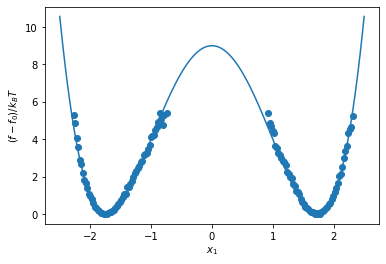

Text(0.5, 1.0, '$X = g(z)$')

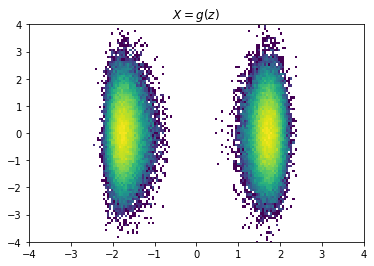

In [6]:
x_brute=brute_sample(E,100000)
plot_energy(x_brute[:,0])

ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X = g(z)$')

## Model

In [7]:
class RealNVP_stochastic(nn.Module):
  def __init__(self,stochastic=False,step_size=0.25,nsteps=10,n_hidden=256,prior=None,n_block=5,masks=None,nets=None,nett=None,target=True):
    super(RealNVP_stochastic,self).__init__()
    self.stochastic=stochastic
    self.step_size=step_size
    self.nsteps=nsteps
    self.target=target

    if nets==None:
      nets = lambda: nn.Sequential(nn.Linear(2, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, 2), nn.Tanh())
    if nett==None:
      nett = lambda: nn.Sequential(nn.Linear(2, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, 2))

    if prior==None:
      self.prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

    self.n_hidden=n_hidden
    self.n_block=n_block
    if masks==None:
      self.masks = nn.Parameter(torch.from_numpy(np.array([[0, 1], [1, 0]] * self.n_block).astype(np.float32)), requires_grad=False)

    self.nett = torch.nn.ModuleList([nett() for _ in range(len(self.masks))]) # translation
    self.nets = torch.nn.ModuleList([nets() for _ in range(len(self.masks))]) # scaling 

  def target_energy(self,x):
    target=self.target
    if target==None:
      return self.prior_energy(x)
    elif target==True:
      return self.proposal_energy(x)

  def proposal_energy(self, x, a=1, b=-6, c=0, d=1):
    if (len(x.shape) > 1):
      return a*x[:,0]**4 + b*x[:,0]**2 + c*x[:,0] + d*x[:,1]**2/2
    else:
      return a*x[0]**4 + b*x[0]**2 + c*x[0] + d*x[1]**2/2

  def prior_energy(self, z):
    return 0.5*torch.linalg.norm(z,dim=1)**2


  def MCMC_forward(self, x ):
    stepsize=self.step_size
    nsteps=self.nsteps
    E0 = self.target_energy(x).reshape((x.shape[0],1))
    Et = E0
    for i in range(nsteps):
        # proposal step
        dx = stepsize * torch.zeros_like(x).normal_()
        xprop = x + dx
        Eprop = self.target_energy(xprop).reshape((x.shape[0],1))
        # acceptance step
        acc = (torch.rand(x.shape[0],1) < torch.exp(-(Eprop - Et))).float() 
        x = (1-acc) * x + acc * xprop
        Et = (1-acc) * Et + acc * Eprop

    dW = (Et - E0).reshape(x.shape[0],)
    return x, dW

  def MCMC_backward(self, z):
    stepsize=self.step_size
    nsteps=self.nsteps
    E0 = self.prior_energy(z).reshape((z.shape[0],1))
    Et = E0
    for i in range(nsteps):
        # proposal step
        dz = stepsize * torch.zeros_like(z).normal_()
        zprop = z + dz
        Eprop = self.prior_energy(zprop).reshape((z.shape[0],1))
        # acceptance step
        acc = (torch.rand(z.shape[0],1) < torch.exp(-(Eprop - Et))).float()
        z = (1-acc) * z + acc * zprop
        Et = (1-acc) * Et + acc * Eprop

    dW = (Et - E0).reshape(z.shape[0],)
    return z, dW


  def forward_flow(self,z):
    stochastic=self.stochastic
    log_R_zx, x = z.new_zeros(z.shape[0]), z

    for i in range(len(self.masks)):
      x1= x*self.masks[i]

      s=self.nets[i](x1)*(1-self.masks[i])
      t=self.nett[i](x1)*(1-self.masks[i])

      x=x1+(1-self.masks[i])* (x*torch.exp(s)+t)
      log_R_zx+=torch.sum(s,-1)
      if stochastic==True:
        x,dw=self.MCMC_forward(x)
        log_R_zx+=dw
    return x, log_R_zx

  def backward_flow(self,x):
    stochastic=self.stochastic
    log_R_xz, z = x.new_zeros(x.shape[0]), x

    for i in reversed(range(len(self.masks))):
      if stochastic==True:
        z, dw=self.MCMC_backward(z)
        log_R_xz+=dw

      z1= z*self.masks[i]

      s=self.nets[i](z1)*(1-self.masks[i])
      t=self.nett[i](z1)*(1-self.masks[i])

      z=z1+(1-self.masks[i])*(z-t)*torch.exp(-s)
      log_R_xz-=torch.sum(s,-1)

    return z, log_R_xz

  def sample(self, batchSize):
      z = self.prior.sample((batchSize,))
      x, log_R_zx = self.forward_flow(z)
      return z.detach().numpy() , x.detach().numpy(), log_R_zx.detach().numpy()

  def loss(self, batch, w_ml = 1.0, w_kl = 0.0, w_rc = 0.0):
      return w_ml*self.loss_ml(batch) + w_kl*self.loss_kl(batch) + w_rc*self.loss_rc(batch)  

  def loss_ml(self, batch_x):
      z, log_R_xz = self.backward_flow(batch_x)
      energy=0.5*torch.linalg.norm(z,dim=1)**2
      return torch.mean(energy-log_R_xz)

  def loss_kl(self, batch_z):
      x, log_R_zx = self.forward_flow(batch_z)
      energy=self.target_energy(x)
#      e_high=1e4
#      for i in range(len(energy)):
#        if abs(energy[i]) == float('inf'):
#                print("energy overflow detected")
#        elif energy[i] > e_high:
#                energy[i] = e_high + torch.log(energy[i] - e_high + 1.0)
      return torch.mean(energy - log_R_zx)  

## BG

#### ML

In [16]:
model_BG=RealNVP_stochastic()

In [17]:
iter1=300
iter2=300
lr1=0.0001
lr2=0.0001
batch_size1=2000
batch_size2=2000

In [18]:

training_data=x_brute
np.random.shuffle(training_data)
training_data.shape

(100000, 2)

In [19]:
optimizer = torch.optim.Adam(model_BG.parameters(), lr=lr1) 

training_data = training_data.astype('float32')

trainloader = data.DataLoader(dataset=training_data, batch_size=batch_size1)

losses = [] 


In [20]:
t = 0 
while t < iter1:
    for batch in trainloader:  
        
        # Custom ML loss function
        loss = model_BG.loss_ml(batch) 
        losses.append(loss.item()) # save values for plotting later 
    
        # Training
        optimizer.zero_grad() # Set grads to zero
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 25: loss = 1.255
iter 50: loss = 0.573
iter 75: loss = 0.309
iter 100: loss = 0.202
iter 125: loss = 0.189
iter 150: loss = 0.148
iter 175: loss = 0.164
iter 200: loss = 0.132
iter 225: loss = 0.152
iter 250: loss = 0.122
iter 275: loss = 0.146
iter 300: loss = 0.117


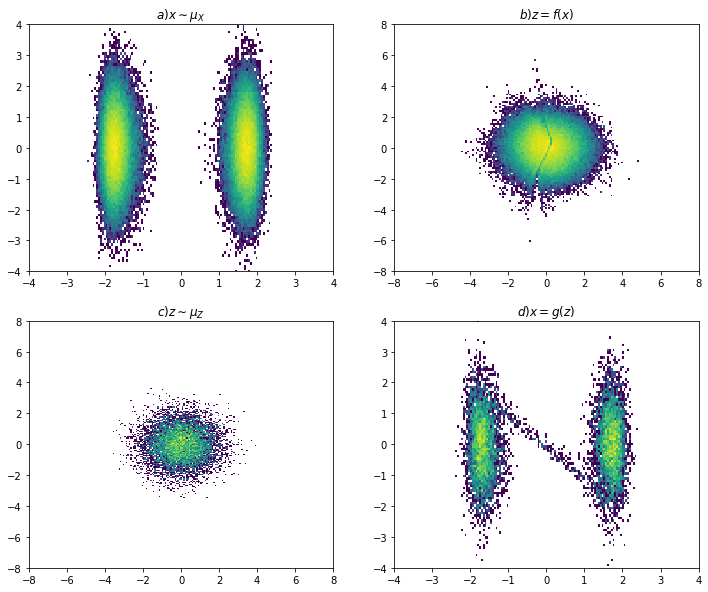

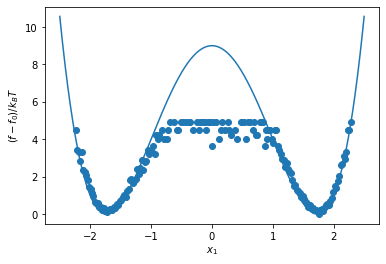

0

In [21]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=model_BG.backward_flow(torch.from_numpy(training_data))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$b) z = f(x)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x, _ = model_BG.sample(10000)
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$c) z \sim \mu_Z$')

# sample 10000 points from prior and transform to target
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

plt.show()

plot_energy(x[:,0]) #plot energy

#### KL

In [22]:

training_set_2 = z.astype('float32')
trainloader_2 = data.DataLoader(dataset=training_set_2, batch_size=batch_size2)
optimizer2 = torch.optim.Adam(model_BG.parameters(), lr=lr2) 
while t < iter1+iter2:
    for batch_z in trainloader_2:  
        # KL loss function
        loss = model_BG.loss_kl(batch_z)
        losses.append(loss.item()) # save values for plotting later 
    
        # Training on KL loss
        optimizer2.zero_grad() # Set grads to zero
        loss.backward(retain_graph=True)
        optimizer2.step()
        
        t = t + 1 # iteration count
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)


iter 325: loss = -7.021
iter 350: loss = -7.089
iter 375: loss = -7.102
iter 400: loss = -7.115
iter 425: loss = -7.115
iter 450: loss = -7.119
iter 475: loss = -7.121
iter 500: loss = -7.124
iter 525: loss = -7.111
iter 550: loss = -7.108
iter 575: loss = -7.105
iter 600: loss = -7.103


Text(0.5, 1.0, '$d) x = g(z)$')

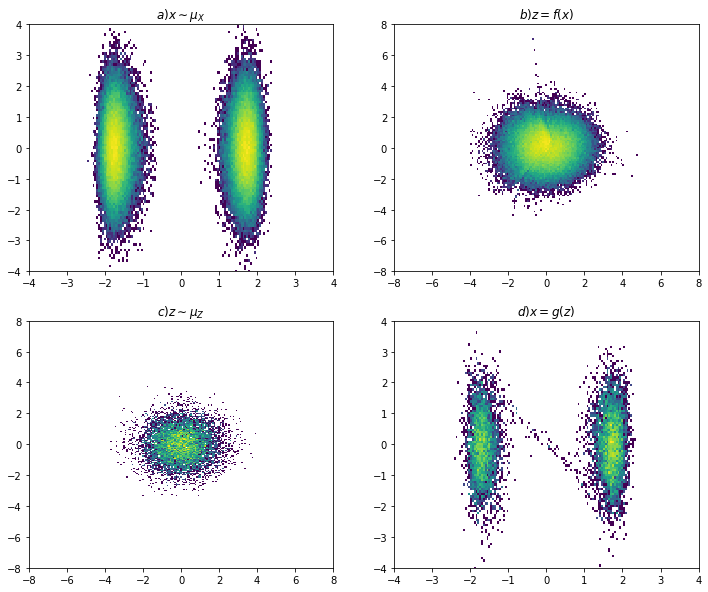

In [23]:

# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=model_BG.backward_flow(torch.from_numpy(training_data))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$b) z = f(x)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x, _ = model_BG.sample(10000)
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$c) z \sim \mu_Z$')

# sample 10000 points from prior and transform to target
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

#plt.show()

#plot_energy(x[:,0]) #plot energy

## SNF

#### ML

In [24]:
model_SNF=RealNVP_stochastic(stochastic=True)

In [25]:
iter1=300
iter2=300
lr1=0.0001
lr2=0.0001
batch_size1=2000
batch_size2=2000

In [26]:

training_data=x_brute
np.random.shuffle(training_data)
training_data.shape

(100000, 2)

In [27]:
optimizer = torch.optim.Adam(model_SNF.parameters(), lr=lr1) 

training_data = training_data.astype('float32')

trainloader = data.DataLoader(dataset=training_data, batch_size=batch_size1)

losses = [] # for visualizing loss as a function of iteration number rather than epoch number


In [28]:
t = 0 # iteration count
while t < iter1:
    for batch in trainloader:  

        # Custom ML loss function
        loss = model_SNF.loss_ml(batch) 
        losses.append(loss.item()) # save values for plotting later 
    
        # Training
        optimizer.zero_grad() # Set grads to zero
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 25: loss = 1.862
iter 50: loss = 1.876
iter 75: loss = 1.842
iter 100: loss = 1.871
iter 125: loss = 1.850
iter 150: loss = 1.866
iter 175: loss = 1.838
iter 200: loss = 1.889
iter 225: loss = 1.843
iter 250: loss = 1.882
iter 275: loss = 1.844
iter 300: loss = 1.883


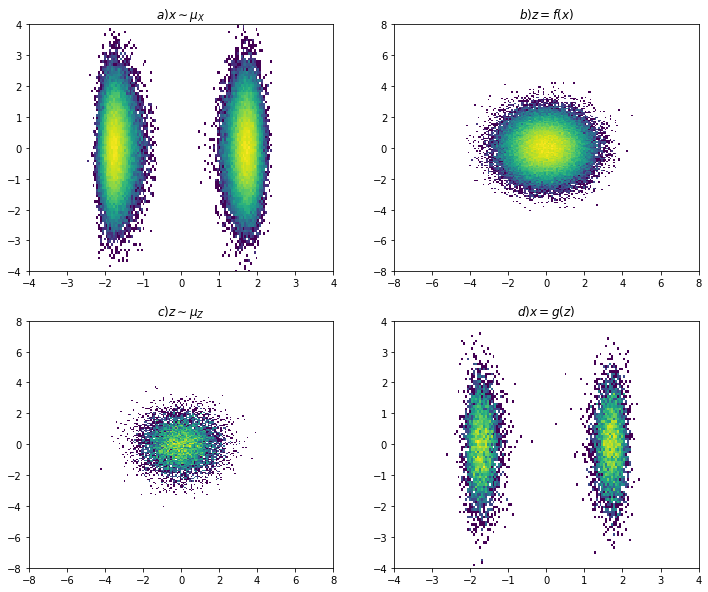

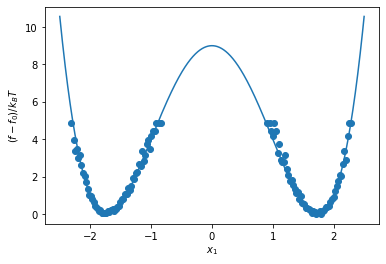

0

In [29]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=model_SNF.backward_flow(torch.from_numpy(training_data))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$b) z = f(x)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x, _ = model_SNF.sample(10000)
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$c) z \sim \mu_Z$')

# sample 10000 points from prior and transform to target
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

plt.show()

plot_energy(x[:,0]) #plot energy

#### KL

In [30]:

training_set_2 = z.astype('float32')
trainloader_2 = data.DataLoader(dataset=training_set_2, batch_size=batch_size2)
optimizer2 = torch.optim.Adam(model_SNF.parameters(), lr=lr2) 
while t < iter1+iter2:
    for batch_z in trainloader_2:  
        # KL loss function
        loss = model_SNF.loss_kl(batch_z)
        losses.append(loss.item()) # save values for plotting later 
    
        # Training on KL loss
        optimizer2.zero_grad() # Set grads to zero
        loss.backward(retain_graph=True)
        optimizer2.step()
        
        t = t + 1 # iteration count
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)


iter 325: loss = -0.810
iter 350: loss = -1.546
iter 375: loss = -2.373
iter 400: loss = -2.454
iter 425: loss = -2.485
iter 450: loss = -2.481
iter 475: loss = -2.493
iter 500: loss = -2.486
iter 525: loss = -2.506
iter 550: loss = -2.500
iter 575: loss = -2.511
iter 600: loss = -2.495


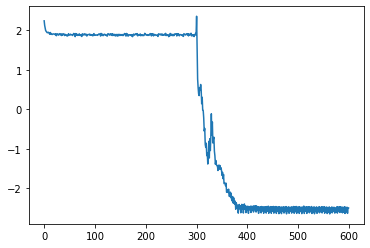

In [31]:
plt.plot(losses)
plt.show()

Text(0.5, 1.0, '$d) x = g(z)$')

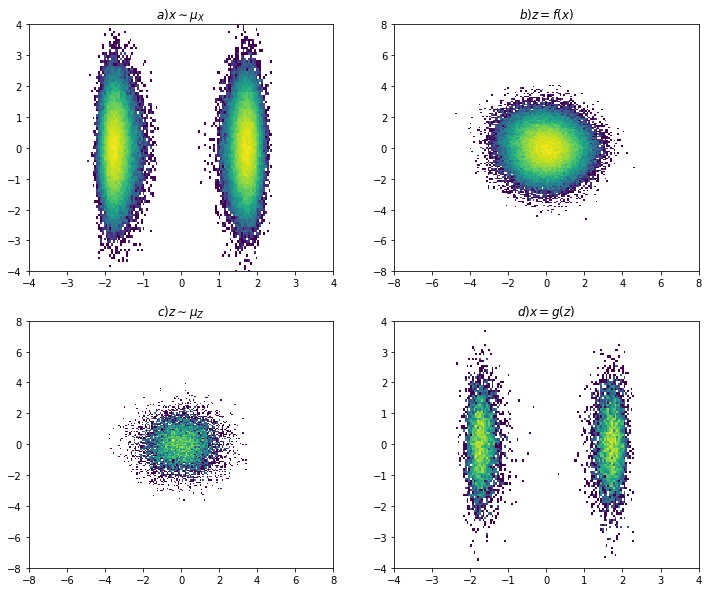

In [32]:

# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=model_SNF.backward_flow(torch.from_numpy(training_data))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$b) z = f(x)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x, _ = model_SNF.sample(10000)
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$c) z \sim \mu_Z$')

# sample 10000 points from prior and transform to target
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

#plt.show()

#plot_energy(x[:,0]) #plot energy
